Compare q from model and presure levels with the integrated water column

In [2]:
import os

import pandas as pd
import xarray as xr
import yaml
import numpy as np
import matplotlib.pyplot as plt

def load_surface_data(variable, date):
    """Load data for given variable and date."""
    filename = f"FloodCase_201305_{variable}.nc"
    filepath = os.path.join(input_folder, filename)
    da = xr.open_dataset(filepath)[variable]

    # Include midnight of the next day (if available)
    extra = date + pd.Timedelta(days=1)
    return da.sel(time=slice(date, extra))

def load_modellevel_data(variable, date):
    """Load model level data for given variable and date."""
    filename = f"FloodCase_201305_ml_{variable}.nc"
    filepath = os.path.join(input_folder, filename)
    da = xr.open_dataset(filepath)[variable]

    # Include midnight of the next day (if available)
    extra = date + pd.Timedelta(days=1)
    return da.sel(time=slice(date, extra)).sel(lev=modellevels)

def load_data(variable, date):
    """Load data for given variable and date."""
    filename = f"FloodCase_201305_{variable}.nc"
    filepath = os.path.join(input_folder, filename)
    da = xr.open_dataset(filepath)[variable]

    # Include midnight of the next day (if available)
    extra = date + pd.Timedelta(days=1)
    return da.sel(time=slice(date, extra))


In [3]:
start_date = '20130521'
end_date = '20130604'


datelist = pd.date_range(
    start=start_date, end=end_date, freq="d", inclusive="left"
)

input_folder = '../data/volume_2/era5_2013'

modellevels = list(np.arange(1,138,2))# + list(np.arange(91,138)) #[1,20,40,60,80,100,105,110,115,120,125,126,127,128,129,130,131,132,133,134,135,136,137]
print(modellevels)
print('how many modellevels: ' + str(len(modellevels)))
g = 9.80665  # [m/s2]

for date in datelist[:1]:
    print(date)

    # Load data
    u_ml = load_modellevel_data("u", date).sel(lev=modellevels).isel(time=0)
    v_ml = load_modellevel_data("v", date).sel(lev=modellevels).isel(time=0)
    q_ml = load_modellevel_data("q", date).sel(lev=modellevels).isel(time=0)
    ml = q_ml.lev
    sp = load_surface_data("sp", date).isel(time=0)
    tcw = load_surface_data("tcw", date).isel(time=0) # kg/m2
    u_pl = load_data("u", date).isel(time=0)
    v_pl = load_data("v", date).isel(time=0)
    q_pl = load_data("q", date).isel(time=0)
    
    # change modellevels to pressure levels
    filenamecsv = 'tableERA5model_to_pressure.csv'
    df = pd.read_csv(os.path.join(input_folder,filenamecsv))
    a = df['a [Pa]'].to_xarray().rename(index='lev').sel(lev=modellevels)
    b = df['b'].to_xarray().rename(index='lev').sel(lev=modellevels) 
    sp_modellevels2 = sp.expand_dims({'lev':modellevels})#,axis=1)
    p_modellevels = a + b*sp_modellevels2 # in Pa
    dp_modellevels = p_modellevels.diff(dim="lev")
    
    #interpolate and calculate dp on pressure levels
    # Create pressure array
    levels = q_pl.level
    p = levels.broadcast_like(u_pl)*100  # Pa
   
    # Interpolate to new levels
    edges = 0.5 * (levels.values[1:] + levels.values[:-1])
    u_pl_edges = u_pl.interp(level=edges)
    v_pl_edges = v_pl.interp(level=edges)
    q_pl_edges = q_pl.interp(level=edges)
    # Calculate pressure jump
    dp = p.diff(dim="level") 
    dp["level"] = edges
    #but still take into account mountains here!!!
    
    # Split in 2 layers
    P_boundary = 0.72878581 * sp + 7438.803223
    lower_layer = (dp.level < sp / 100) & (dp.level > P_boundary / 100)
    upper_layer = dp.level < P_boundary / 100
    total_layer = upper_layer + lower_layer
   
    #calculate column water vapour from model levels and pressure levels
    cwv_ml = (q_ml * dp_modellevels / g).sum(dim='lev')   # column water vapor (kg/m2)
       
    cwv_pl_edges      = (q_pl_edges * dp / g).where(total_layer).sum(dim='level')   # column water vapor (kg/m2) upper layer
    #cwv_pl_edges      = (q_pl_edges * dp / g).where(total_layer)
    q_pl_edges_update = q_pl_edges.where(total_layer)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133, 135, 137]
how many modellevels: 69
2013-05-21 00:00:00


In [4]:
print(lower_layer[:,60,225])
print(P_boundary[60,225])
print(sp[60,225])


<xarray.DataArray (level: 10)>
array([False, False, False, False, False,  True, False, False, False,
       False])
Coordinates:
    time       datetime64[ns] 2013-05-21
  * level      (level) float64 250.0 350.0 450.0 550.0 ... 875.0 925.0 975.0
    longitude  float32 6.25
    latitude   float32 45.0
<xarray.DataArray 'sp' ()>
array(65730.45, dtype=float32)
Coordinates:
    time       datetime64[ns] 2013-05-21
    longitude  float32 6.25
    latitude   float32 45.0
<xarray.DataArray 'sp' ()>
array(79984.62, dtype=float32)
Coordinates:
    time       datetime64[ns] 2013-05-21
    longitude  float32 6.25
    latitude   float32 45.0
Attributes:
    standard_name:  surface_air_pressure
    long_name:      Surface pressure
    units:          Pa


Text(0.5, 1.0, 'Diff between ERA5 tcw and cwv at 12 pressure levels')

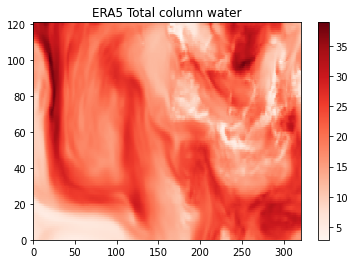

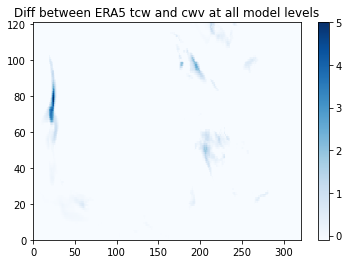

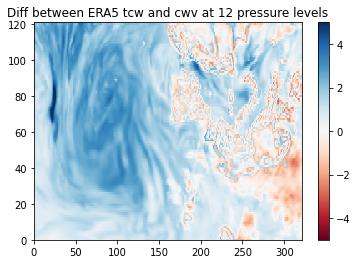

In [5]:
#spatial plot

fig, axs = plt.subplots(1)
var1 = axs.pcolor(tcw,cmap = plt.cm.Reds)
plt.colorbar(var1)
axs.set_title('ERA5 Total column water')

fig, axs = plt.subplots(1)
var1 = axs.pcolor(tcw - cwv_ml, cmap=plt.cm.Blues, vmin =-0.1, vmax=5)
plt.colorbar(var1)
axs.set_title('Diff between ERA5 tcw and cwv at all model levels')

fig1, axs1 = plt.subplots(1)
var2 = axs1.pcolor(tcw - cwv_pl_edges, cmap = plt.cm.RdBu, vmin =-5, vmax=5)
plt.colorbar(var2)
axs1.set_title('Diff between ERA5 tcw and cwv at 12 pressure levels')


Text(0.5, 1.0, 'Percentage diff between ERA5 tcw and cwv at 12 pressure levels')

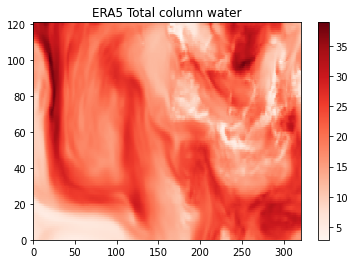

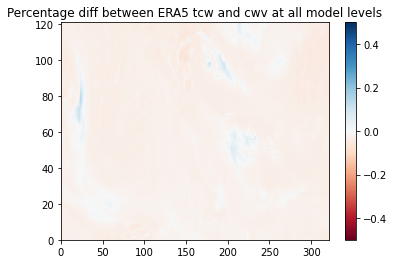

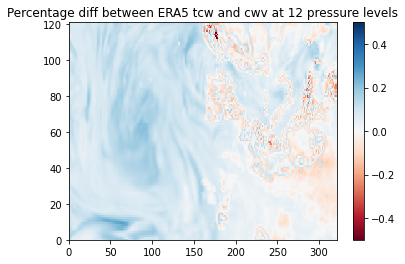

In [7]:
#spatial plot

fig, axs = plt.subplots(1)
var1 = axs.pcolor(tcw,cmap = plt.cm.Reds)
plt.colorbar(var1)
axs.set_title('ERA5 Total column water')

fig, axs = plt.subplots(1)
var1 = axs.pcolor((tcw - cwv_ml)/tcw, cmap=plt.cm.RdBu, vmin =-.5, vmax=.5)
plt.colorbar(var1)
axs.set_title('Percentage diff between ERA5 tcw and cwv at all model levels')

fig1, axs1 = plt.subplots(1)
var2 = axs1.pcolor((tcw - cwv_pl_edges)/tcw, cmap = plt.cm.RdBu, vmin =-.5, vmax=.5)
plt.colorbar(var2)
axs1.set_title('Percentage diff between ERA5 tcw and cwv at 12 pressure levels')

In [17]:
len(tcw.values.flatten())
print(len(cwv_ml.values.flatten()))

38841


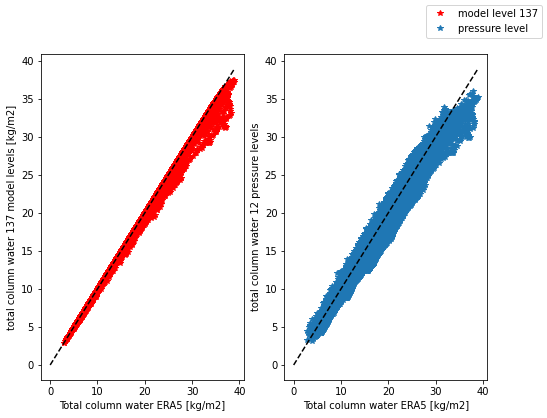

In [31]:
#scatter plot

fig, axs = plt.subplots(1,2, figsize=(8, 6))

axs[0].plot(tcw.values.flatten(), cwv_ml.values.flatten(), 'r*', label = 'model level 137')
axs[0].set_xlabel('Total column water ERA5 [kg/m2]')
axs[0].set_ylabel('total column water 137 model levels [kg/m2]')
axs[0].plot(np.arange(0,40),np.arange(0,40),'k--')

axs[1].plot(tcw.values.flatten(), cwv_pl_edges.values.flatten(), '*', label='pressure level')
axs[1].set_xlabel('Total column water ERA5 [kg/m2]')
axs[1].set_ylabel('total column water 12 pressure levels')
axs[1].plot(np.arange(0,40),np.arange(0,40),'k--')

fig.legend()

In [1]:
print('Max difference between ERA5 and model levels:' + str((tcw.values.flatten() - cwv_ml.values.flatten()).max()))
print('Max difference between ERA5 and pressure levels:' + str((tcw.values.flatten() - cwv_pl_edges.values.flatten()).max()))

NameError: name 'tcw' is not defined

It seems there is still an underestimation of the water column using 137 model levels compared. 
Yes because I compare with total water and not total water vapour

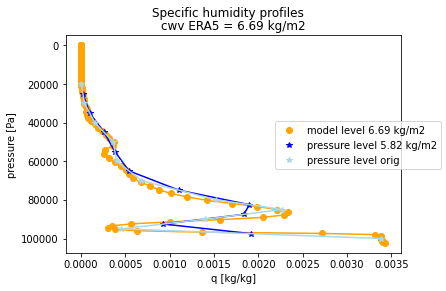

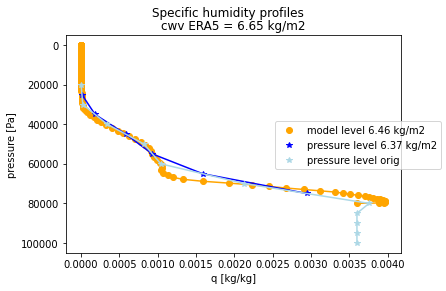

In [29]:
fig, axs = plt.subplots(1)
fig.suptitle('Specific humidity profiles')

axs.plot(q_ml[:,0,0],p_modellevels[:,0,0],'o', color= 'orange', label = 'model level '+ format(cwv_ml[0,0].values,".2f") + ' kg/m2')
axs.plot(q_ml[:,0,0],p_modellevels[:,0,0],'-', color= 'orange')
axs.plot(q_pl_edges[:,0,0],edges*100,'*', color= 'blue', label ='pressure level '+ format(cwv_pl_edges[0,0].values,".2f") + ' kg/m2')
axs.plot(q_pl_edges[:,0,0],edges*100,'-', color= 'blue')
axs.plot(q_pl[:,0,0],levels*100,'*', color= 'lightblue', label ='pressure level orig')
axs.plot(q_pl[:,0,0],levels*100,'-', color= 'lightblue')
axs.set_title('cwv ERA5 = ' + format(tcw[0,0].values,".2f") + ' kg/m2')
plt.gca().invert_yaxis()
axs.set_xlabel('q [kg/kg]')
axs.set_ylabel('pressure [Pa]')
fig.legend(loc='center right')


fig1, axs1 = plt.subplots(1)
fig1.suptitle('Specific humidity profiles')
axs1.plot(q_ml[:,60,225],p_modellevels[:,60,225],'o', color= 'orange', label = 'model level '+ format(cwv_ml[60,225].values,".2f") + ' kg/m2')
axs1.plot(q_ml[:,60,225],p_modellevels[:,60,225],'-', color= 'orange')
axs1.plot(q_pl_edges_update[:,60,225],edges*100,'*', color= 'blue', label ='pressure level '+ format(cwv_pl_edges[60,225].values,".2f") + ' kg/m2')
axs1.plot(q_pl_edges_update[:,60,225],edges*100,'-', color= 'blue')
axs1.plot(q_pl[:,60,225],levels*100,'*', color= 'lightblue', label ='pressure level orig')
axs1.plot(q_pl[:,60,225],levels*100,'-', color= 'lightblue')
axs1.set_title('cwv ERA5 = ' + format(tcw[60,225].values,".2f") + ' kg/m2')
plt.gca().invert_yaxis()
axs1.set_xlabel('q [kg/kg]')
axs1.set_ylabel('pressure [Pa]')
fig1.legend(loc='center right')
